In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# فصل ۳ — تحلیل اکتشافی داده‌ها (EDA)
## درس ۴: کاهش بُعد (مقدمه‌ای بر PCA)

کاهش بُعد یکی از ایده‌های بسیار کاربردی در تحلیل اکتشافی داده‌هاست: به شما کمک می‌کند وقتی تعداد ویژگی‌ها زیاد است، داده را **خلاصه** کنید، **قابل‌تصویر** کنید و **عیب‌یابی** انجام دهید. در این درس، **تحلیل مؤلفه‌های اصلی (Principal Component Analysis یا PCA)** را از اصول پایه یاد می‌گیریم، آن را به جبر خطی (مقادیر ویژه و SVD) وصل می‌کنیم و سپس در پایتون روی چند دیتاست واقعی همین مخزن اجرا می‌کنیم.

---

### بعد از این درس چه توانایی‌هایی خواهید داشت
- توضیح دهید چرا در EDA به کاهش بُعد نیاز داریم (افزونگی، چندهمخطی، تصویرسازی، نویز).
- PCA را به‌صورت یک مسئله بهینه‌سازی فرمول‌بندی کنید و با تجزیه مقدارِ ویژه حل کنید.
- PCA را به‌صورت دستی با NumPy محاسبه کنید و با `sklearn.decomposition.PCA` اعتبارسنجی کنید.
- مؤلفه‌های اصلی را با **بارگذاری‌ها (loadings)**، **واریانس توضیح‌داده‌شده** و شهود بای‌پلات تفسیر کنید.
- PCA را به‌عنوان تقریب کم‌رتبهٔ بهینه (دیدگاه Eckart–Young / SVD) درک کنید.
- PCA را در جریان کاری مدل‌سازی به‌درستی استفاده کنید (پرهیز از نشت اطلاعات؛ برازش تبدیل‌ها فقط روی آموزش).
- PCA (و یک جایگزین مناسب برای ماتریس‌های تنک) را روی موارد زیر اعمال کنید:
  - یک دیتاست کاملاً عددی و کلاسیک (Iris)،
  - یک جدول عددی با ویژگی‌های بیشتر (Wine Quality)،
  - یک دیتاست با انواع دادهٔ ترکیبی (Diamonds) با one-hot encoding + TruncatedSVD،
  - و یک دیتاست عددی چندکلاسه (Fish) تا ببینیم PCA با کلاس‌های بیشتر چگونه رفتار می‌کند.

## ۱) چرا کاهش بُعد در EDA زیاد دیده می‌شود؟

دیتاست‌های واقعی معمولاً این ویژگی‌ها را دارند:
- **ویژگی‌های افزونه**: چند ستون تقریباً یک سیگنال را منتقل می‌کنند.
- **چندهمخطی (Multicollinearity)**: روابط خطی قوی بین پیش‌بین‌ها.
- **اندازه‌گیری‌های نویزی**: بعضی ستون‌ها عمدتاً نویز هستند اما بُعد ظاهری را زیاد می‌کنند.
- **مقیاس‌های متفاوت**: یک ویژگی با مقیاس بزرگ ممکن است بر ویژگی‌های کوچک‌مقیاس غالب شود.
- **اثرهای هندسهٔ بُعد بالا**: فاصله‌ها «تجمع» می‌کنند و همسایگی کمتر معنی‌دار می‌شود.

هدف کاهش بُعد یافتن نمایش کم‌بُعدی است که مهم‌ترین ساختار را حفظ کند. در EDA، PCA به‌ویژه ارزشمند است چون:
- نمای ۲بعدی/۳بعدی از داده با تصویر کردن (projection) می‌دهد؛
- واریانس را بر حسب جهت‌ها تجزیه می‌کند؛
- رابطهٔ ویژگی‌ها را از طریق بارگذاری‌های مؤلفه‌ها آشکار می‌کند.

PCA خطی است و محورهای جدید را به‌صورت **ترکیب خطی** از ویژگی‌های اولیه می‌سازد. این محدودیت یک مزیت هم هست: PCA قابل‌تفسیر، سریع و از نظر تحلیلی خوب فهمیده شده است.

## ۲) PCA از دید هندسی: تصویر کردن روی محورهای جدید

فرض کنید $n$ نمونه و $d$ ویژگی عددی دارید. پس از مرکزکردن (کم کردن میانگین هر ویژگی)، PCA جهت‌هایی را پیدا می‌کند که تصویر کردن داده روی آن‌ها بیشترین مقدار ممکن از واریانس را حفظ کند.

اگر $x_i \in \mathbb{R}^d$ مشاهداتِ مرکز‌شده باشند، تصویر تک‌بُعدی روی بردار یکه $w$ برابر است با:
$$
z_i = w^\top x_i.
$$

از نظر هندسی:
- $w$ یک جهت در فضای ویژگی‌هاست؛
- $z_i$ مختصات نمونه‌ها روی آن جهت است؛
- $w$ طوری انتخاب می‌شود که ابر نقاطِ تصویر شده بیشترین «پراکندگی» را داشته باشد.

این معیار «بیشینه کردن واریانس» با حفظ اطلاعات در یک مدل خطی ارتباط نزدیک دارد: اگر داده را روی یک زیرفضای خطی فشرده کنید و سپس بازسازی نمایید، بهترین زیرفضا (از نظر خطای مربعی) همان زیرفضای PCA است (بعداً این موضوع را اثبات می‌کنیم).

## ۳) PCA به‌صورت بهینه‌سازی و راه‌حلِ مقدارِ ویژه

اگر $X \in \mathbb{R}^{n \times d}$ ماتریس دادهٔ مرکز‌شده باشد (سطرها نمونه‌ها هستند)، کوواریانس نمونه‌ای:
$$
S = \frac{1}{n-1} X^\top X \in \mathbb{R}^{d \times d}.
$$

برای بردار یکه $w$ (یعنی $w^\top w = 1$)، واریانس تصویر برابر است با:
$$
\mathrm{Var}(Xw) = w^\top S w.
$$

پس جهت مؤلفهٔ اول مسئلهٔ زیر را حل می‌کند:
$$
\max_{w \in \mathbb{R}^d}\; w^\top S w \quad \text{subject to } w^\top w = 1.
$$

### اثبات (ضرایب لاگرانژ)
لاگرانژین را در نظر بگیرید:
$$
\mathcal{L}(w, \lambda) = w^\top S w - \lambda (w^\top w - 1).
$$
مشتق نسبت به $w$:
$$
\nabla_w \mathcal{L} = 2Sw - 2\lambda w = 0 \;\Rightarrow\; Sw = \lambda w.
$$
پس $w$ باید **بردار ویژه**‌ی $S$ باشد و مقدار تابع هدف برابر می‌شود با:
$$
w^\top S w = w^\top (\lambda w) = \lambda.
$$
بنابراین بیشینه کردن واریانس یعنی انتخاب بردار ویژهٔ متناظر با **بزرگ‌ترین مقدار ویژه**.

### چند مؤلفه و عمودبودن
برای $k$ مؤلفه، PCA ماتریسِ یکه-متعامد $W_k = [w_1,\dots,w_k]$ را پیدا می‌کند به‌طوری‌که $W_k^\top W_k = I_k$. نمایش کم‌بُعد:
$$
Z = X W_k \in \mathbb{R}^{n \times k}.
$$

یک خاصیت کلیدی: مؤلفه‌ها **نامرتبط (uncorrelated)** هستند:
$$
\mathrm{Cov}(Z) = W_k^\top S W_k
$$
اگر $W_k$ از بردارهای ویژه ساخته شده باشد، این ماتریس قطری خواهد بود.

## ۴) PCA با SVD (مسیرِ پایدار عددی)

به جای تجزیه مقدارِ ویژهٔ $S$، بسیاری از پیاده‌سازی‌ها از SVD روی ماتریس دادهٔ مرکز‌شده استفاده می‌کنند:
$$
X = U \Sigma V^\top.
$$

ارتباط SVD با کوواریانس:
$$
S = \frac{1}{n-1} X^\top X = \frac{1}{n-1} V \Sigma^2 V^\top.
$$

پس:
- **جهت‌های اصلی** ستون‌های $V$ هستند؛
- **مقادیر ویژه** برابر $\Sigma^2/(n-1)$ هستند؛
- مختصات تصویر شده $Z = XV_k = U \Sigma_k$ است.

در عمل این نکته مهم است چون:
- SVD معمولاً پایدار و کاراست؛
- وقتی $d$ بزرگ است، از ساختن صریح $S$ جلوگیری می‌کند؛
- نسخه‌های تصادفی/تدریجی (randomized / incremental) را برای سرعت و پردازش جریانی ممکن می‌سازد.

## ۵) مرکزکردن و مقیاس‌بندی: PCA بر پایهٔ کوواریانس یا همبستگی

PCA همیشه **مرکزکردن** را فرض می‌کند (کم کردن میانگین ویژگی‌ها). اما مقیاس‌بندی یک انتخاب مدل‌سازی است:

- **PCA بر پایهٔ کوواریانس**: PCA روی ویژگی‌های خامِ مرکز‌شده. ویژگی‌هایی با مقیاس عددی بزرگ‌تر معمولاً واریانس را غالب می‌کنند.
- **PCA بر پایهٔ همبستگی**: ابتدا هر ویژگی را استاندارد کنید (میانگین ۰ و واریانس ۱) سپس PCA. در این حالت PCA بیشتر بازتابِ *همبستگی‌ها* است نه واریانس خام.

در اغلب EDAها وقتی واحدها متفاوت‌اند (مثلاً دلار در برابر کیلومتر)، استانداردسازی توصیه می‌شود.

در scikit-learn الگوی رایج:
1) `StandardScaler()`
2) `PCA()`

ما همین الگو را دنبال می‌کنیم و همچنین PCA را «دستی» محاسبه می‌کنیم تا دقیقاً ببینیم کتابخانه چه می‌کند.

## ۶) PCA به‌عنوان بازسازی بهینه (چرا PCA فقط «جادوی واریانس» نیست؟)

یک توجیه عمیق‌تر برای PCA این است که بهترین تقریب خطیِ $k$-بعدی را از نظر خطای مربعی می‌دهد.

فرض کنید $X$ مرکز‌شده است. می‌خواهیم هر نقطه $x_i$ را با تصویر آن روی یک زیرفضای $k$-بعدی تقریب بزنیم؛ این زیرفضا توسط ستون‌های متعامد-یکهٔ $W_k$ تولید می‌شود (یعنی $W_k^\top W_k = I_k$). بازسازی برابر است با:
$$
\hat{X} = X W_k W_k^\top.
$$

خطای بازسازی کلی با نُرم فروبنیوس:
$$
\|X - \hat{X}\|_F^2 = \|X - X W_k W_k^\top\|_F^2.
$$

**ادعا:** $W_k$ای که این خطا را کمینه می‌کند دقیقاً ماتریسِ $k$ بردارِ تکین راستِ برترِ $X$ است (یا معادل آن، $k$ بردار ویژهٔ برترِ ماتریس کوواریانس).

### شهود
- تصویر کردن روی یک زیرفضا، مؤلفه‌های داده در راستای زیرفضا را نگه می‌دارد و بخش عمود را حذف می‌کند.
- بهترین زیرفضا زیرفضایی است که بیشترین «انرژی» کلیِ $X$ را جذب کند.
- چون $\|X\|_F^2$ برابر مجموع مربعِ مقادیر تکین است، گرفتن $k$ جهت تکینِ برتر بهینه است.

### قضیه Eckart–Young (بیان)
اگر $X = U\Sigma V^\top$ تجزیه SVD باشد و $\Sigma_k$ فقط $k$ مقدار تکینِ بزرگ‌تر را نگه دارد، بهترین تقریب رتبه-$k$:
$$
X_k = U_k \Sigma_k V_k^\top
$$
است و در میان همهٔ ماتریس‌های رتبه-$k$، $\|X - X_k\|_F$ را کمینه می‌کند.

به همین دلیل PCA یک روش فشرده‌سازی هم هست: بهترین خلاصهٔ کم‌رتبه و خطی از دادهٔ مرکز‌شده را ارائه می‌دهد.

## ۷) سفیدسازی (Whitening) و نامرتبط‌سازی

اگر $Z = X W_k$ امتیازهای PCA باشند و کوواریانس $Z$ قطری باشد:
$$
\mathrm{Cov}(Z) = \Lambda_k,
$$
که $\Lambda_k$ شامل $k$ مقدار ویژهٔ اول است.

نمایش **سفیدشده** هر مؤلفه را طوری مقیاس می‌کند که واریانس آن ۱ شود:
$$
Z_{\text{white}} = Z \Lambda_k^{-1/2}.
$$

در نتیجه:
$$
\mathrm{Cov}(Z_{\text{white}}) = I_k.
$$

Whitening گاهی قبل از خوشه‌بندی یا روش‌های مبتنی بر فاصله استفاده می‌شود، اما می‌تواند در مؤلفه‌های با واریانس کوچک نویز را تقویت کند. در EDA، سفیدسازی بیشتر یک ابزار تشخیصی است.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.decomposition import PCA, TruncatedSVD, IncrementalPCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error

In [3]:
def read_csv_rel(rel_path: str) -> pd.DataFrame:
    # Read a CSV using a repository-relative path (e.g., ../../../Datasets/...).
    # Raises a clear error if the file is not found.
    p = Path(rel_path)
    if not p.exists():
        raise FileNotFoundError(
            f"Dataset not found at relative path: {rel_path}\n"
            f"Current working directory: {Path.cwd()}\n"
            "Tip: open/run this notebook from the Tutorials/English/Chapter3 or Tutorials/Persian/Chapter3 folder."
        )
    return pd.read_csv(p)

def plot_corr_heatmap(df: pd.DataFrame, title: str):
    corr = df.corr(numeric_only=True)
    plt.figure(figsize=(8, 6))
    plt.imshow(corr.values, aspect="auto")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.title(title)
    plt.colorbar(label="correlation")
    plt.tight_layout()
    plt.show()

def choose_k_by_variance(explained_variance_ratio, threshold=0.95) -> int:
    cum = np.cumsum(explained_variance_ratio)
    return int(np.searchsorted(cum, threshold) + 1)

def reconstruction_mse(X_std, pca_model, k: int) -> float:
    Wk = pca_model.components_[:k, :]
    Zk = X_std @ Wk.T
    X_hat = Zk @ Wk
    return float(np.mean((X_std - X_hat) ** 2))

## ۸) برنامهٔ اجرایی این درس

در این درس روی چهار دیتاست همین مخزن کار می‌کنیم:

1) **Iris** (Classification/iris.csv): ویژگی‌های عددی + برچسب کلاس؛ عالی برای اعتبارسنجی ریاضی PCA.
2) **Wine Quality** (Classification/Wine_Quality.csv): جدول عددی با ویژگی‌های بیشتر؛ مناسب برای همبستگی و بارگذاری‌ها.
3) **Diamonds** (Regression/diamonds.csv): ترکیبی از عددی و دسته‌ای؛ از one-hot + TruncatedSVD استفاده می‌کنیم.
4) **Fish** (Classification/fish.csv): ویژگی‌های عددی + چند کلاس؛ می‌بینیم کلاس‌های متعدد در فضای PCA چگونه پخش می‌شوند.

مسیرها را به‌صورت نسبی نسبت به ساختار مخزن می‌نویسیم؛ مثلاً:
`../../../Datasets/Classification/iris.csv`.

اکنون وارد واردکردن کتابخانه‌ها و توابع کمکی می‌شویم.

In [4]:
iris_path = "../../../Datasets/Classification/iris.csv"
df_iris = read_csv_rel(iris_path)

display(df_iris.head())
print("Shape:", df_iris.shape)
print(df_iris.dtypes)

,sepal_length,sepal_width,petal_length,petal_width,classification
0,5.4,3.7,1.5,0.2,Iris-setosa
1,4.8,3.4,1.6,0.2,Iris-setosa
2,4.8,3.0,1.4,0.1,Iris-setosa
3,4.3,3.0,1.1,0.1,Iris-setosa
4,5.8,4.0,1.2,0.2,Iris-setosa


Shape: (150, 5)
sepal_length      float64
sepal_width       float64
petal_length      float64
petal_width       float64
classification     object
dtype: object


## ۹) دیتاست A: Iris — PCA دستی و PCA در scikit-learn

با `iris.csv` شروع می‌کنیم که چهار ویژگی عددی و یک برچسب کلاس به نام `classification` دارد.

PCA در اینجا بسیار مناسب است برای:
- تصویرسازی دوبعدی؛
- تفسیر اینکه کدام اندازه‌گیری‌ها بیشترین واریانس را توضیح می‌دهند؛
- مقایسه و اعتبارسنجی PCA دستی در برابر `sklearn`.

In [5]:
feature_cols = [c for c in df_iris.columns if c != "classification"]
X = df_iris[feature_cols].to_numpy(dtype=float)
y = df_iris["classification"].astype(str).to_numpy()

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

print("Feature means (after scaling):", X_std.mean(axis=0))
print("Feature stds  (after scaling):", X_std.std(axis=0, ddof=0))

Feature means (after scaling): [-5.21064673e-16 -6.63173220e-16  3.31586610e-16 -2.84217094e-16]
Feature stds  (after scaling): [1. 1. 1. 1.]


### ۹.۱ استانداردسازی

از PCA بر پایهٔ همبستگی استفاده می‌کنیم؛ یعنی ویژگی‌ها را استاندارد می‌کنیم (میانگین ۰ و واریانس ۱). این کار مانع می‌شود یک ویژگی فقط به خاطر واحد اندازه‌گیری بزرگ، غالب شود.

In [6]:
n = X_std.shape[0]
S = (X_std.T @ X_std) / (n - 1)

eigvals, eigvecs = np.linalg.eigh(S)
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

explained_var_ratio_manual = eigvals / eigvals.sum()

print("Eigenvalues:", eigvals)
print("Explained variance ratio (manual):", explained_var_ratio_manual)

Eigenvalues: [2.93035378 0.92740362 0.14834223 0.02074601]
Explained variance ratio (manual): [0.72770452 0.23030523 0.03683832 0.00515193]


### ۹.۲ PCA دستی با تجزیه مقدارِ ویژه

چون ماتریس استانداردشده تقریباً مرکز‌شده است، محاسبه می‌کنیم:
$$
S = \frac{1}{n-1}X^\top X
$$
و سپس تجزیه مقدارِ ویژهٔ ماتریس متقارن $S$ را انجام می‌دهیم. با مرتب‌سازی نزولیِ مقادیر ویژه، مؤلفه‌ها بر اساس واریانس توضیح‌داده‌شده مرتب می‌شوند.

In [7]:
pca = PCA(n_components=4, random_state=42)
Z = pca.fit_transform(X_std)

print("Explained variance ratio (sklearn):", pca.explained_variance_ratio_)
print("Difference vs manual:", pca.explained_variance_ratio_ - explained_var_ratio_manual)

C = np.abs(eigvecs.T @ pca.components_.T)
display(pd.DataFrame(
    C,
    index=[f"manual_PC{i+1}" for i in range(C.shape[0])],
    columns=[f"sk_PC{i+1}" for i in range(C.shape[1])]
))

Explained variance ratio (sklearn): [0.72770452 0.23030523 0.03683832 0.00515193]
Difference vs manual: [0. 0. 0. 0.]


,sk_PC1,sk_PC2,sk_PC3,sk_PC4
manual_PC1,1.000000e+00,3.202172e-16,1.229823e-16,2.518350e-17
manual_PC2,3.202172e-16,1.000000e+00,3.004095e-16,5.618528e-17
manual_PC3,1.229823e-16,3.004095e-16,1.000000e+00,8.912821e-17
manual_PC4,2.518350e-17,5.618528e-17,8.912821e-17,1.000000e+00


### ۹.۳ اعتبارسنجی با PCA در scikit-learn

نسبت واریانس توضیح‌داده‌شده را مقایسه می‌کنیم و هم‌راستایی مؤلفه‌ها را بررسی می‌کنیم. توجه کنید: جهت‌های اصلی از نظر علامت یکتا نیستند (بردارهای $w$ و $-w$ معادل‌اند).

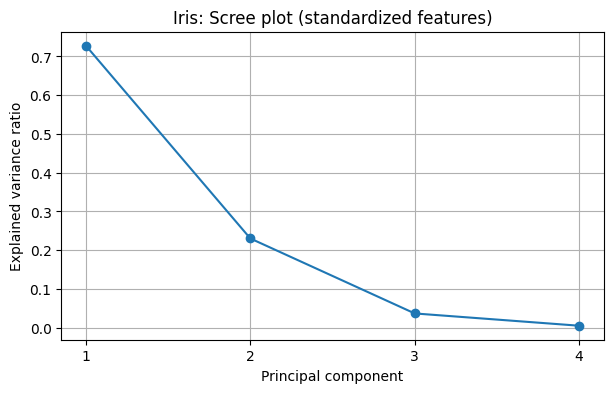

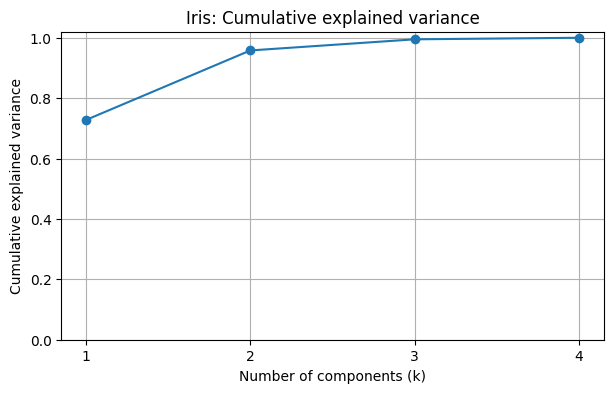

Cumulative explained variance: [0.72770452 0.95800975 0.99484807 1.        ]


In [8]:
evr = pca.explained_variance_ratio_
cum_evr = np.cumsum(evr)

plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, len(evr)+1), evr, marker="o")
plt.xticks(np.arange(1, len(evr)+1))
plt.xlabel("Principal component")
plt.ylabel("Explained variance ratio")
plt.title("Iris: Scree plot (standardized features)")
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, len(cum_evr)+1), cum_evr, marker="o")
plt.xticks(np.arange(1, len(cum_evr)+1))
plt.xlabel("Number of components (k)")
plt.ylabel("Cumulative explained variance")
plt.title("Iris: Cumulative explained variance")
plt.ylim(0, 1.02)
plt.grid(True)
plt.show()

print("Cumulative explained variance:", cum_evr)

### ۹.۴ نمودار Scree، واریانس تجمعی و انتخاب $k$

نمودارهای Scree و واریانس تجمعی خروجی‌های استاندارد در EDA هستند. این نمودارها انتخاب $k$ را سریع و قابل‌دفاع می‌کنند.

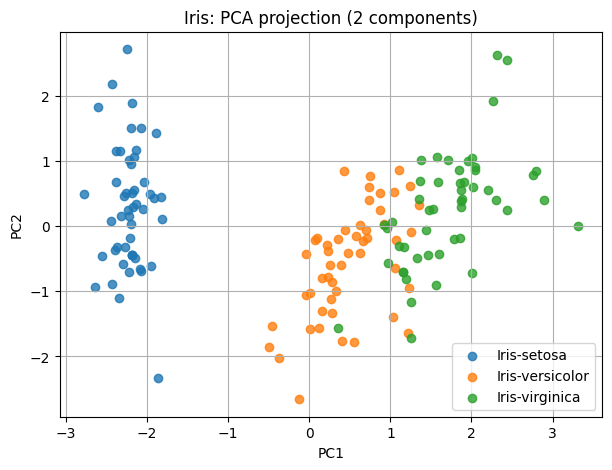

In [9]:
Z2 = Z[:, :2]
classes = np.unique(y)

plt.figure(figsize=(7, 5))
for c in classes:
    mask = (y == c)
    plt.scatter(Z2[mask, 0], Z2[mask, 1], label=c, alpha=0.8)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Iris: PCA projection (2 components)")
plt.legend()
plt.grid(True)
plt.show()

### ۹.۵ تصویر دوبعدی و جدایش کلاس‌ها

دو مؤلفه اول را رسم می‌کنیم و با رنگ‌بندی کلاس، ساختار جدایش را بررسی می‌کنیم.

In [10]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=feature_cols,
    columns=[f"PC{i+1}" for i in range(pca.components_.shape[0])]
)

display(loadings[["PC1", "PC2"]])

,PC1,PC2
sepal_length,0.522372,0.372318
sepal_width,-0.263355,0.925556
petal_length,0.581254,0.021095
petal_width,0.565611,0.065416


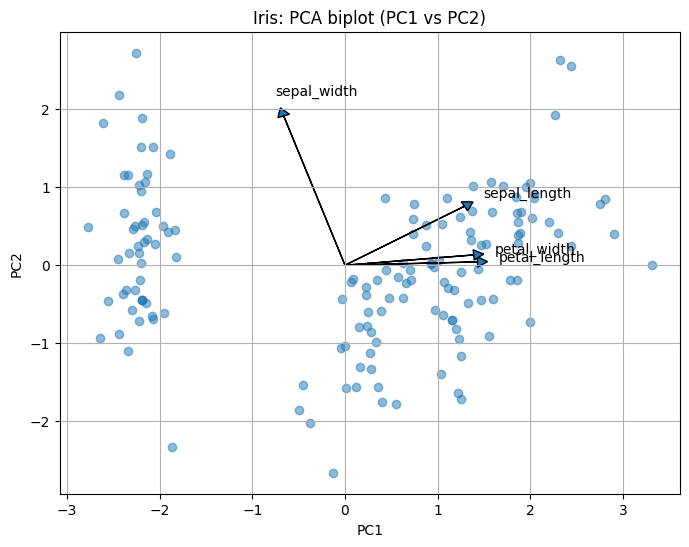

In [11]:
def biplot(scores_2d, loadings_2d, feature_names, title="Biplot"):
    plt.figure(figsize=(8, 6))
    plt.scatter(scores_2d[:, 0], scores_2d[:, 1], alpha=0.5)

    scale = np.max(np.abs(scores_2d), axis=0) * 0.8
    for i, name in enumerate(feature_names):
        x, yv = loadings_2d[i, 0] * scale[0], loadings_2d[i, 1] * scale[1]
        plt.arrow(0, 0, x, yv,
                  head_width=0.05*scale[0], head_length=0.05*scale[1],
                  length_includes_head=True)
        plt.text(x * 1.08, yv * 1.08, name)

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.grid(True)
    plt.show()

biplot(Z2, pca.components_[:2, :].T, feature_cols, title="Iris: PCA biplot (PC1 vs PC2)")

### ۹.۶ بارگذاری‌ها و شهود بای‌پلات

بارگذاری‌ها نشان می‌دهند هر مؤلفه از کدام ویژگی‌های اولیه ساخته شده است. بای‌پلات امتیازهای نمونه‌ها و بردارهای بارگذاری را روی یک نمودار می‌آورد تا تفسیر ساده‌تر شود.

,k,reconstruction_MSE
0,1,2.722955e-01
1,2,4.199025e-02
2,3,5.151927e-03
3,4,1.934260e-31


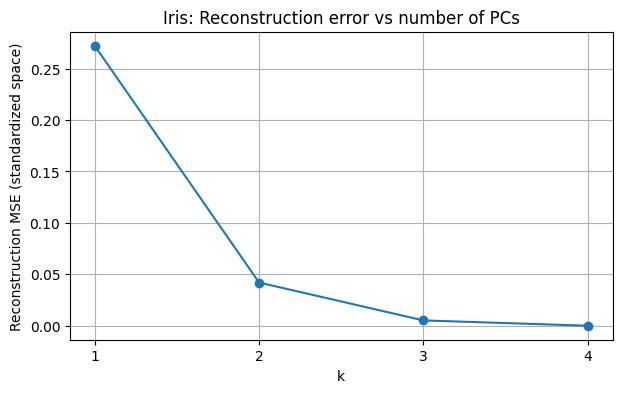

In [12]:
mses = [reconstruction_mse(X_std, pca, k) for k in range(1, X_std.shape[1] + 1)]
display(pd.DataFrame({"k": np.arange(1, len(mses)+1), "reconstruction_MSE": mses}))

plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, len(mses)+1), mses, marker="o")
plt.xticks(np.arange(1, len(mses)+1))
plt.xlabel("k")
plt.ylabel("Reconstruction MSE (standardized space)")
plt.title("Iris: Reconstruction error vs number of PCs")
plt.grid(True)
plt.show()

### ۹.۷ خطای بازسازی بر حسب $k$

می‌توان PCA را به‌صورت فشرده‌سازی و سپس بازسازی دید. ما MSE بازسازی را در فضای استانداردشده محاسبه می‌کنیم تا میزان اطلاعات از دست‌رفته با استفاده از $k$ مؤلفه را کمّی کنیم.

In [13]:
# Outlier sensitivity: add a strong outlier and compare PC1 direction
X_out = X_std.copy()
X_out[0, :] = X_out[0, :] + 8.0  # shift one sample strongly

pca_clean = PCA(n_components=2, random_state=42).fit(X_std)
pca_out   = PCA(n_components=2, random_state=42).fit(X_out)

w1_clean = pca_clean.components_[0]
w1_out   = pca_out.components_[0]

# Angle between PC1 directions (absolute, because sign can flip)
cosang = np.abs(np.dot(w1_clean, w1_out) / (np.linalg.norm(w1_clean) * np.linalg.norm(w1_out)))
angle_deg = np.degrees(np.arccos(np.clip(cosang, -1, 1)))

print("Angle between PC1 (clean vs with outlier) in degrees:", angle_deg)
print("PC1 loadings (clean):", w1_clean)
print("PC1 loadings (outlier):", w1_out)

Angle between PC1 (clean vs with outlier) in degrees: 22.51460642627027
PC1 loadings (clean): [ 0.52237162 -0.26335492  0.58125401  0.56561105]
PC1 loadings (outlier): [0.58079679 0.12258221 0.57258583 0.56550346]


### ۹.۹ سفیدسازی و نامرتبط‌سازی (مثال Iris)

کوواریانس امتیازهای PCA را محاسبه می‌کنیم و سپس سفیدسازی انجام می‌دهیم تا ببینیم PCA چگونه کوواریانس را قطری می‌کند و سفیدسازی چگونه واریانس هر مؤلفه را به ۱ می‌رساند.

In [14]:
k = 2
Zk = Z[:, :k]
lambdas = pca.explained_variance_[:k]
Z_white = Zk / np.sqrt(lambdas)

cov_Z = np.cov(Zk.T)
cov_white = np.cov(Z_white.T)

print("Covariance of PCA scores (should be ~diagonal):\n", cov_Z)
print("\nCovariance after whitening (should be ~I):\n", cov_white)

Covariance of PCA scores (should be ~diagonal):
 [[ 2.93035378e+00 -9.53748639e-17]
 [-9.53748639e-17  9.27403622e-01]]

Covariance after whitening (should be ~I):
 [[ 1.0000000e+00 -1.1921858e-16]
 [-1.1921858e-16  1.0000000e+00]]


### ۹.۱۰ PCA در یک پایپ‌لاین مدل‌سازیِ درست

رگرسیون لجستیک را با و بدون PCA مقایسه می‌کنیم و از `Pipeline` استفاده می‌کنیم تا مطمئن شویم استانداردسازی و PCA فقط روی دادهٔ آموزشی (در هر fold) fit می‌شوند.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

baseline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

with_pca = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2, random_state=42)),
    ("clf", LogisticRegression(max_iter=2000))
])

baseline.fit(X_train, y_train)
with_pca.fit(X_train, y_train)

pred_base = baseline.predict(X_test)
pred_pca = with_pca.predict(X_test)

print("Holdout accuracy (baseline):", accuracy_score(y_test, pred_base))
print("Holdout accuracy (with PCA, k=2):", accuracy_score(y_test, pred_pca))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_base = cross_val_score(baseline, X, y, cv=cv, scoring="accuracy")
cv_pca  = cross_val_score(with_pca, X, y, cv=cv, scoring="accuracy")

print("\nCV accuracy baseline:", cv_base.mean(), "+/-", cv_base.std())
print("CV accuracy PCA     :", cv_pca.mean(), "+/-", cv_pca.std())

Holdout accuracy (baseline): 0.9210526315789473
Holdout accuracy (with PCA, k=2): 0.8947368421052632

CV accuracy baseline: 0.9533333333333334 +/- 0.04521553322083511
CV accuracy PCA     : 0.9133333333333333 +/- 0.04521553322083511


### ۹.۸ آزمایش حساسیت به نقاط دورافتاده (نمایش سریع)

PCA به نقاط دورافتاده حساس است چون بر اساس لحظات مرتبه دوم (واریانس/کوواریانس) عمل می‌کند. یک outlier مصنوعی می‌سازیم و می‌بینیم جهت‌های PC چگونه ممکن است بچرخند. این آزمایش یادآوری می‌کند که مدیریت outlier بخشی از EDA مسئولانه است.

In [16]:
wine_path = "../../../Datasets/Classification/Wine_Quality.csv"
df_wine = read_csv_rel(wine_path)

display(df_wine.head())
print("Shape:", df_wine.shape)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Shape: (4898, 12)


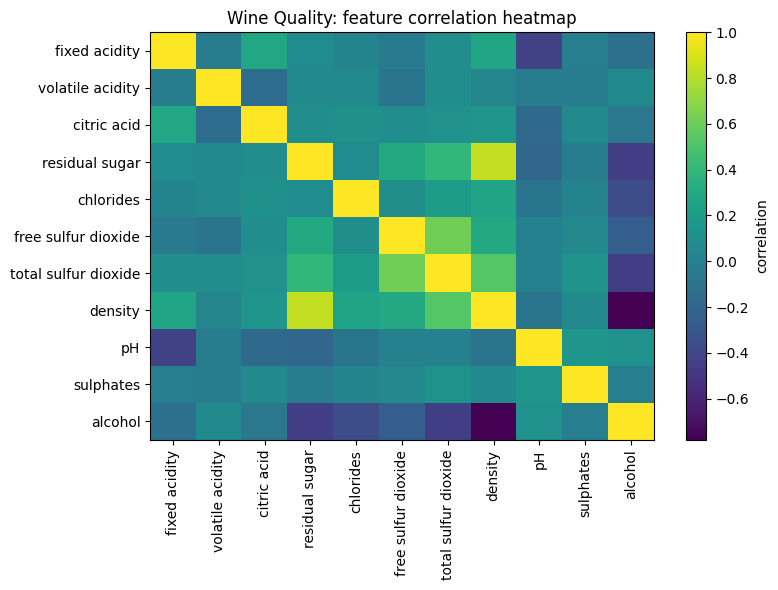

In [17]:
plot_corr_heatmap(df_wine.drop(columns=["quality"]), title="Wine Quality: feature correlation heatmap")

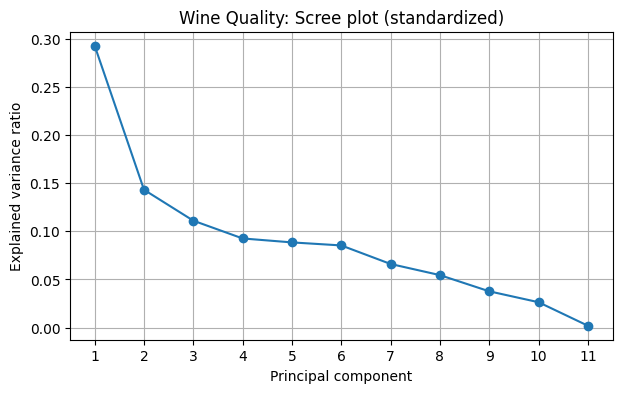

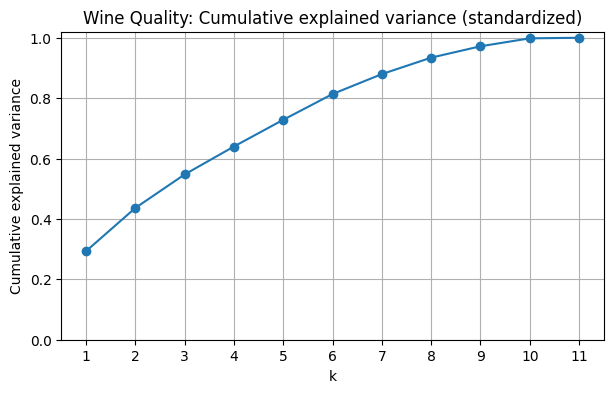

k for 90% variance: 8
k for 95% variance: 9


In [18]:
Xw = df_wine.drop(columns=["quality"]).to_numpy(dtype=float)
yw = df_wine["quality"].to_numpy(dtype=float)

scaler_w = StandardScaler()
Xw_std = scaler_w.fit_transform(Xw)

pca_w = PCA(n_components=min(12, Xw_std.shape[1]), random_state=42)
Zw = pca_w.fit_transform(Xw_std)

evr_w = pca_w.explained_variance_ratio_
cum_w = np.cumsum(evr_w)

plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, len(evr_w)+1), evr_w, marker="o")
plt.xticks(np.arange(1, len(evr_w)+1))
plt.xlabel("Principal component")
plt.ylabel("Explained variance ratio")
plt.title("Wine Quality: Scree plot (standardized)")
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, len(cum_w)+1), cum_w, marker="o")
plt.xticks(np.arange(1, len(cum_w)+1))
plt.xlabel("k")
plt.ylabel("Cumulative explained variance")
plt.title("Wine Quality: Cumulative explained variance (standardized)")
plt.ylim(0, 1.02)
plt.grid(True)
plt.show()

print("k for 90% variance:", choose_k_by_variance(evr_w, 0.90))
print("k for 95% variance:", choose_k_by_variance(evr_w, 0.95))

In [19]:
# Compare with unscaled PCA (covariance PCA) to see effect of units
Xw_centered = Xw - Xw.mean(axis=0, keepdims=True)
pca_w_raw = PCA(n_components=min(12, Xw_centered.shape[1]), random_state=42)
Zw_raw = pca_w_raw.fit_transform(Xw_centered)

evr_raw = pca_w_raw.explained_variance_ratio_

df_compare = pd.DataFrame({
    "PC": np.arange(1, len(evr_w)+1),
    "EVR_standardized": evr_w,
    "EVR_unscaled": evr_raw[:len(evr_w)]
})
display(df_compare.head(10))

,PC,EVR_standardized,EVR_unscaled
0,1,0.292932,9.096573e-01
1,2,0.143204,7.933386e-02
2,3,0.111061,1.015427e-02
3,4,0.092593,5.060045e-04
4,5,0.088485,3.234094e-04
5,6,0.085340,8.727697e-06
6,7,0.066054,6.729866e-06
7,8,0.054487,5.390609e-06
8,9,0.037649,4.070021e-06
9,10,0.026317,1.865253e-07


In [20]:
wine_features = [c for c in df_wine.columns if c != "quality"]
load_w = pd.DataFrame(
    pca_w.components_.T,
    index=wine_features,
    columns=[f"PC{i+1}" for i in range(pca_w.components_.shape[0])]
)

def top_loadings(loadings_df, pc_name, top=8):
    s = loadings_df[pc_name].copy()
    return pd.DataFrame({
        "feature": s.index,
        "loading": s.values,
        "abs_loading": np.abs(s.values)
    }).sort_values("abs_loading", ascending=False).head(top)

display(top_loadings(load_w, "PC1", top=10))
display(top_loadings(load_w, "PC2", top=10))

,feature,loading,abs_loading
7,density,0.511524,0.511524
10,alcohol,-0.437238,0.437238
3,residual sugar,0.427408,0.427408
6,total sulfur dioxide,0.406652,0.406652
5,free sulfur dioxide,0.300334,0.300334
4,chlorides,0.212011,0.212011
0,fixed acidity,0.157218,0.157218
2,citric acid,0.144050,0.144050
8,pH,-0.128832,0.128832
9,sulphates,0.043379,0.043379


,feature,loading,abs_loading
0,fixed acidity,0.587558,0.587558
8,pH,-0.581344,0.581344
2,citric acid,0.345295,0.345295
5,free sulfur dioxide,-0.290355,0.290355
6,total sulfur dioxide,-0.244032,0.244032
9,sulphates,-0.222695,0.222695
1,volatile acidity,-0.051728,0.051728
10,alcohol,0.035569,0.035569
4,chlorides,0.008800,0.008800
3,residual sugar,-0.008749,0.008749


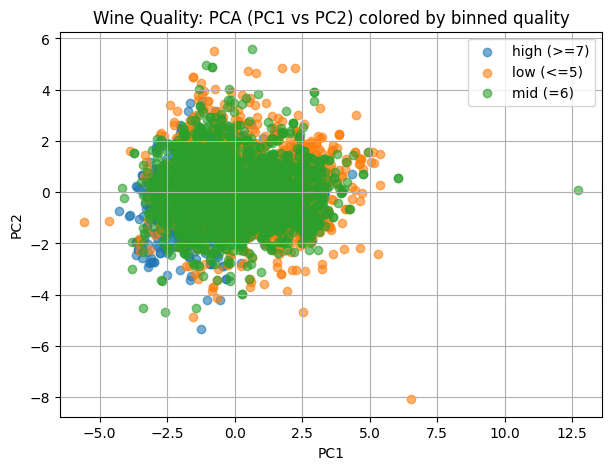

In [21]:
quality_bin = np.where(yw <= 5, "low (<=5)", np.where(yw == 6, "mid (=6)", "high (>=7)"))

plt.figure(figsize=(7, 5))
for c in np.unique(quality_bin):
    m = (quality_bin == c)
    plt.scatter(Zw[m, 0], Zw[m, 1], label=c, alpha=0.6)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Wine Quality: PCA (PC1 vs PC2) colored by binned quality")
plt.legend()
plt.grid(True)
plt.show()

### تفسیر مقایسهٔ با/بدون مقیاس

اگر PCA بدون مقیاس‌بندی بیشترِ واریانس را به چند مؤلفه اختصاص دهد، ممکن است فقط به این دلیل باشد که برخی ویژگی‌ها بازهٔ عددی بزرگی دارند. استانداردسازی باعث می‌شود PCA بیشتر ساختار *همبستگی* را بیان کند نه واحد اندازه‌گیری.

در EDA یک عادت خوب این است که:
- PCA استانداردشده را برای تفسیر اجرا کنید؛
- و در صورت نیاز PCA بدون مقیاس را هم برای دیدن سلطهٔ واحدها بررسی کنید.

## ۱۰) دیتاست B: Wine Quality — همبستگی‌ها، اثر مقیاس و تفسیر

`Wine_Quality.csv` ویژگی‌های عددی متعددی با واحدهای فیزیکی معنی‌دار دارد. کارهای زیر را انجام می‌دهیم:
- ساختار همبستگی را بررسی می‌کنیم؛
- PCA با استانداردسازی را اجرا می‌کنیم (انتخاب پیشنهادی)؛
- با PCA بدون مقیاس‌بندی مقایسه می‌کنیم تا اثر واحدها را ببینیم؛
- بارگذاری‌های بزرگِ PCهای اولیه را تفسیر می‌کنیم؛
- و در صورت تمایل، با باین‌کردن کیفیت، مؤلفه‌های PCA را در یک پایپ‌لاین پیش‌بینی ساده استفاده می‌کنیم.

In [22]:
# Simple predictive comparison: bin quality into a binary label and compare with/without PCA
y_bin = (yw >= 7).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    Xw, y_bin, test_size=0.25, random_state=42, stratify=y_bin
)

baseline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

with_pca = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=choose_k_by_variance(evr_w, 0.90), random_state=42)),
    ("clf", LogisticRegression(max_iter=2000))
])

baseline.fit(X_train, y_train)
with_pca.fit(X_train, y_train)

pred_base = baseline.predict(X_test)
pred_pca = with_pca.predict(X_test)

print("Holdout accuracy (baseline):", accuracy_score(y_test, pred_base))
print("Holdout accuracy (with PCA):", accuracy_score(y_test, pred_pca))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_base = cross_val_score(baseline, Xw, y_bin, cv=cv, scoring="accuracy")
cv_pca  = cross_val_score(with_pca, Xw, y_bin, cv=cv, scoring="accuracy")

print("\nCV accuracy baseline:", cv_base.mean(), "+/-", cv_base.std())
print("CV accuracy PCA     :", cv_pca.mean(), "+/-", cv_pca.std())

Holdout accuracy (baseline): 0.8073469387755102
Holdout accuracy (with PCA): 0.8057142857142857

CV accuracy baseline: 0.8013451877175795 +/- 0.006286326244556573
CV accuracy PCA     : 0.7970586395947552 +/- 0.008962806379522601


In [23]:
diamonds_path = "../../../Datasets/Regression/diamonds.csv"
df_dia = read_csv_rel(diamonds_path)

display(df_dia.head())
print("Shape:", df_dia.shape)

,id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Shape: (53940, 11)


In [24]:
df_dia_s = df_dia.sample(n=min(8000, len(df_dia)), random_state=42).copy()

y_price = df_dia_s["price"].to_numpy(dtype=float)
X_dia = df_dia_s.drop(columns=["id", "price"], errors="ignore")

num_cols = X_dia.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_dia.columns if c not in num_cols]

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

Numeric columns: ['carat', 'depth', 'table', 'x', 'y', 'z']
Categorical columns: ['cut', 'color', 'clarity']


In [25]:
preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

svd = TruncatedSVD(n_components=10, random_state=42)

pipe_svd = Pipeline([
    ("prep", preprocess),
    ("svd", svd)
])

Z_dia = pipe_svd.fit_transform(X_dia)

print("Reduced shape:", Z_dia.shape)
print("Explained variance ratio (TruncatedSVD):", svd.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(svd.explained_variance_ratio_))

Reduced shape: (8000, 10)
Explained variance ratio (TruncatedSVD): [0.48195821 0.15844002 0.08351136 0.01225284 0.02846294 0.02720396
 0.02494677 0.02428518 0.02197678 0.02125126]
Cumulative explained variance: [0.48195821 0.64039823 0.72390959 0.73616243 0.76462537 0.79182933
 0.8167761  0.84106128 0.86303806 0.88428931]


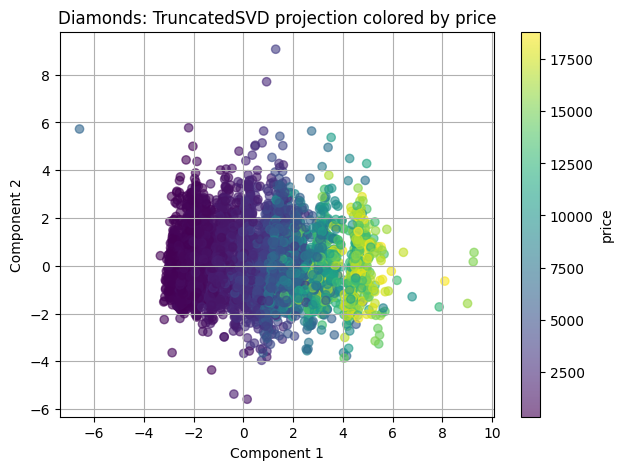

In [26]:
plt.figure(figsize=(7, 5))
sc = plt.scatter(Z_dia[:, 0], Z_dia[:, 1], c=y_price, alpha=0.6)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Diamonds: TruncatedSVD projection colored by price")
plt.grid(True)
plt.colorbar(sc, label="price")
plt.show()

## ۱۱) دیتاست C: Diamonds — انواع ترکیبی و TruncatedSVD

برای داده‌های جدولی با انواع ترکیبی، one-hot encoding معمولاً یک ماتریس تنک و پُربُعد می‌سازد. PCA استاندارد روی ماتریس چگال می‌تواند ناکارا باشد؛ بنابراین از `TruncatedSVD` استفاده می‌کنیم که مستقیماً روی ماتریس‌های تنک کار می‌کند و عوامل نهفته شبیه PCA تولید می‌کند.

کارهایی که انجام می‌دهیم:
- پیش‌پردازش ویژگی‌های عددی و دسته‌ای؛
- کاهش بُعد به تعداد کمی مؤلفه؛
- تصویرسازی دوبعدی و رنگ‌بندی با قیمت؛
- و بررسی ویژگی‌های با وزن بزرگ در مؤلفهٔ اول.

In [27]:
ohe = pipe_svd.named_steps["prep"].named_transformers_["cat"]
num_names = num_cols
cat_names = ohe.get_feature_names_out(cat_cols).tolist() if len(cat_cols) > 0 else []
feature_names = num_names + cat_names

for j in [0, 1, 2]:
    comp = svd.components_[j]
    df_comp = pd.DataFrame({"feature": feature_names, "weight": comp})
    df_comp["abs_weight"] = np.abs(df_comp["weight"])
    print(f"Top contributors for Component {j+1}:")
    display(df_comp.sort_values("abs_weight", ascending=False).head(12))

Top contributors for Component 1:


,feature,weight,abs_weight
3,x,0.495305,0.495305
4,y,0.494876,0.494876
5,z,0.492310,0.492310
0,carat,0.489631,0.489631
2,table,0.129872,0.129872
21,clarity_SI2,0.053833,0.053833
8,cut_Ideal,-0.051151,0.051151
9,cut_Premium,0.032204,0.032204
24,clarity_VVS1,-0.024559,0.024559
12,color_E,-0.024234,0.024234


Top contributors for Component 2:


,feature,weight,abs_weight
2,table,0.691794,0.691794
1,depth,-0.673539,0.673539
8,cut_Ideal,-0.170022,0.170022
9,cut_Premium,0.141098,0.141098
5,z,-0.110864,0.110864
0,carat,-0.056505,0.056505
4,y,-0.030742,0.030742
3,x,-0.028004,0.028004
10,cut_Very Good,0.018212,0.018212
6,cut_Fair,-0.017907,0.017907


Top contributors for Component 3:


,feature,weight,abs_weight
1,depth,0.657656,0.657656
2,table,0.521520,0.521520
8,cut_Ideal,-0.470282,0.470282
23,clarity_VS2,-0.117160,0.117160
14,color_G,-0.099272,0.099272
13,color_F,-0.078450,0.078450
4,y,-0.077659,0.077659
22,clarity_VS1,-0.075306,0.075306
3,x,-0.069558,0.069558
12,color_E,-0.068244,0.068244


In [28]:
fish_path = "../../../Datasets/Classification/fish.csv"
df_fish = read_csv_rel(fish_path)

display(df_fish.head())
print("Shape:", df_fish.shape)

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


Shape: (159, 7)


## ۱۲) دیتاست D: Fish — PCA با کلاس‌های متعدد

دیتاست `fish.csv` شامل اندازه‌گیری‌های عددی و برچسب گونه (Species) است. مراحل:
- استانداردسازی ویژگی‌های عددی؛
- اجرای PCA؛
- تصویرسازی دو مؤلفهٔ اول با رنگ‌بندی گونه؛
- و تفسیر اینکه کدام اندازه‌گیری‌ها بر PC1 و PC2 غالب‌اند.

این یک کاربرد رایج در EDA است: وقتی چند کلاس دارید، PCA یک نمای کلی سریع از هم‌پوشانی یا جدایش کلاس‌ها می‌دهد.

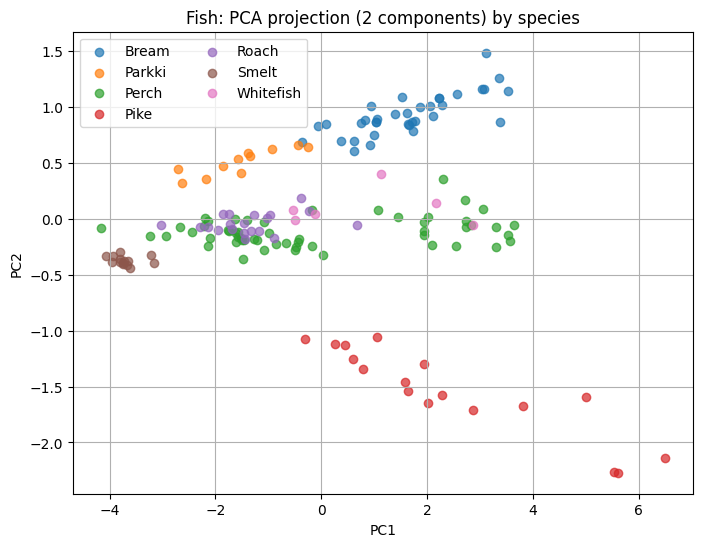

,PC1,PC2
Weight,0.417321,-0.039633
Length1,0.421535,-0.335106
Length2,0.423419,-0.308638
Length3,0.427658,-0.196821
Height,0.342727,0.842910
Width,0.410505,0.204058


In [29]:
# Fish: numeric PCA + multi-class visualization
fish_label = "Species"
fish_features = [c for c in df_fish.columns if c != fish_label]

Xf = df_fish[fish_features].to_numpy(dtype=float)
yf = df_fish[fish_label].astype(str).to_numpy()

Xf_std = StandardScaler().fit_transform(Xf)
pca_f = PCA(n_components=2, random_state=42).fit(Xf_std)
Zf = pca_f.transform(Xf_std)

plt.figure(figsize=(8, 6))
for c in np.unique(yf):
    m = (yf == c)
    plt.scatter(Zf[m, 0], Zf[m, 1], label=c, alpha=0.7)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Fish: PCA projection (2 components) by species")
plt.legend(ncol=2)
plt.grid(True)
plt.show()

load_f = pd.DataFrame(
    pca_f.components_.T,
    index=fish_features,
    columns=["PC1", "PC2"]
)
display(load_f)

## ۱۳) PCA تدریجی (پردازش جریانی / داده بزرگ)

وقتی دیتاست‌ها آن‌قدر بزرگ‌اند که به‌راحتی در حافظه جا نمی‌شوند، `IncrementalPCA` داده را به صورت مینی‌بچ پردازش می‌کند. ریاضیات همچنان شبیه PCA است، اما الگوریتم برآوردها را به‌تدریج به‌روزرسانی می‌کند.

در این درس، API را روی Wine Quality نشان می‌دهیم تا ببینید PCA جریانی را چگونه ساختار می‌دهید.

## ۱۴) نکات و خطاهای رایج برای PCA در EDA

1) **مقیاس‌بندی مهم است.** بدون استانداردسازی، ویژگی‌های بزرگ‌مقیاس واریانس را غالب می‌کنند.
2) **PCA به outlier حساس است.** نقاط دورافتاده می‌توانند جهت‌های اصلی را منحرف کنند.
3) **ابهام علامت.** علامت مؤلفه‌ها یکتا نیست؛ تفسیر را نسبی انجام دهید.
4) **واریانس مساوی مفید بودن نیست.** جهت‌های کم‌واریانس ممکن است برای هدف پیش‌بینی مهم باشند.
5) **نشت اطلاعات ممنوع.** اگر PCA قبل از مدل استفاده می‌شود، فقط روی آموزش fit کنید (`Pipeline`).
6) **مقادیر گمشده را مدیریت کنید.** PCA با NaN کار نمی‌کند؛ ابتدا impute یا حذف کنید.
7) **مبادلهٔ تفسیرپذیری.** PCA ویژگی‌ها را مخلوط می‌کند؛ بارگذاری‌ها کمک می‌کنند اما همچنان ترکیبی‌اند.
8) **محدودیت خطی.** PCA ساختار خطی را می‌گیرد؛ روش‌های غیرخطی (مثل kernel PCA، t-SNE، UMAP) الگوهای دیگر را می‌بینند اما مشکلات خاص خود را دارند.

PCA یک ابزار عالی برای EDA است حتی اگر هرگز در تولید از آن استفاده نکنید.

## ۱۷) تفسیر عمیق‌تر: بارگذاری‌های مربعی، اشتراک‌پذیری (communality) و سهم متغیرها

در EDA معمولاً این سؤال پیش می‌آید که «کدام متغیرهای اولیه بیشترین سهم را در مؤلفه‌های اول دارند؟»
بارگذاری‌های خام مفیدند، اما برای تحلیل سهم متغیرها دو کمیت مشتق‌شده رایج است.

### ۱۷.۱ بارگذاری‌های مربعی
اگر $w_{ij}$ بارگذاری ویژگی $i$ روی مؤلفه $j$ باشد، آنگاه $w_{ij}^2$ نشان می‌دهد سهم ویژگی $i$ در جهت PC$j$ چقدر است. چون مؤلفه‌های PCA بردارهای یکه هستند، برای هر مؤلفه $j$ داریم:
$$
\sum_{i=1}^d w_{ij}^2 = 1.
$$
پس $w_{ij}^2$ را می‌توان به‌صورت یک «کسر» از وزن جهت مؤلفه تفسیر کرد که از ویژگی $i$ می‌آید.

### ۱۷.۲ اشتراک‌پذیری (Communality)
اگر $k$ مؤلفه اول را نگه دارید، اشتراک‌پذیری ویژگی $i$ برابر است با:
$$
h_i^2 = \sum_{j=1}^k w_{ij}^2.
$$
اگر $h_i^2$ نزدیک ۱ باشد یعنی ویژگی $i$ با $k$ مؤلفه اول به‌خوبی نمایش داده می‌شود؛ اگر کوچک باشد یعنی بخش زیادی از تغییرات ویژگی خارج از زیرفضای کم‌بُعد قرار دارد.

در PCA استانداردشده (PCA همبستگی)، اشتراک‌پذیری‌ها شهود بیشتری دارند چون هر ویژگی در ابتدا واریانس ۱ دارد.

در ادامه برای Iris (k=2) بارگذاری‌های مربعی و اشتراک‌پذیری را محاسبه می‌کنیم.

In [30]:
# Squared loadings and communalities for Iris (k=2)
W = pca.components_.T  # shape (d, d)
sq_load = W**2
sq_load_df = pd.DataFrame(sq_load[:, :2], index=feature_cols, columns=["PC1_sq_loading", "PC2_sq_loading"])
sq_load_df["communality_k2"] = sq_load_df["PC1_sq_loading"] + sq_load_df["PC2_sq_loading"]

display(sq_load_df.sort_values("communality_k2", ascending=False))
print("Check per-PC sum of squared loadings (should be 1):", sq_load_df[["PC1_sq_loading","PC2_sq_loading"]].sum(axis=0).values)

,PC1_sq_loading,PC2_sq_loading,communality_k2
sepal_width,0.069356,0.856655,0.926011
sepal_length,0.272872,0.138621,0.411493
petal_length,0.337856,0.000445,0.338301
petal_width,0.319916,0.004279,0.324195


Check per-PC sum of squared loadings (should be 1): [1. 1.]


## ۱۸) PCA به‌صورت «چرخش» + برش: چرا مؤلفه‌ها نامرتبط‌اند؟

می‌توان PCA را به‌عنوان تغییرِ پایه در فضای ویژگی‌ها دید. پس از مرکزکردن و (در صورت نیاز) استانداردسازی، ماتریس کوواریانس $S$ را دارید.
انتخاب بردارهای ویژه $W$ برای $S$ باعث می‌شود:
$$
W^\top S W = \Lambda
$$
که $\Lambda$ قطری است. این قطری‌سازی یعنی در مختصات جدید $Z = XW$، مؤلفه‌ها با هم همبستگی ندارند.

به بیان دیگر، PCA یک چرخش (و احتمالاً بازتاب) به پایه‌ای انجام می‌دهد که کوواریانس در آن قطری است.
اگر سپس فقط $k$ مؤلفه اول را نگه دارید، پایه را به زیرفضای کم‌بُعد «برش» می‌دهید.
به همین دلیل گاهی گفته می‌شود: «PCA = چرخشِ نامرتبط‌ساز + برشِ فشرده‌ساز».

از دید EDA:
- اگر دو ویژگی همبستگی شدید داشته باشند، PCA معمولاً اطلاعات مشترک آن‌ها را در یک یا دو مؤلفه متمرکز می‌کند.
- اگر یک ویژگی تقریباً ترکیب خطی بقیه باشد، یک مقدار ویژه کوچک ظاهر می‌شود که نشانهٔ افزونگی است.

## ۱۹) تشخیص‌ها: فاصله در فضای امتیاز ($T^2$) و فاصلهٔ باقیمانده (SPE / آماره $Q$)

برای غربالگری ناهنجاری‌ها در PCA دو تشخیص مکمل رایج است:

### ۱۹.۱ فاصله امتیاز (Hotelling’s $T^2$)
برای امتیازهای $k$ مؤلفه اول و مقادیر ویژه $\lambda_1,\dots,\lambda_k$:
$$
T^2_i = \sum_{j=1}^k \frac{z_{ij}^2}{\lambda_j}.
$$
$T^2$ بزرگ یعنی نقطه درون زیرفضای PCA «افراطی» است.

### ۱۹.۲ فاصله باقیمانده (Squared Prediction Error / SPE)
اگر $\hat{x}_i$ بازسازی $x_i$ با $k$ مؤلفه (در فضای استانداردشده) باشد:
$$
\mathrm{SPE}_i = \|x_i - \hat{x}_i\|_2^2.
$$
SPE بزرگ یعنی نقطه بیرون از زیرفضای PCA رفتار غیرعادی دارد و در ساختار کم‌بُعد خوب جا نمی‌گیرد.

در EDA، استفاده همزمان از این دو کمک می‌کند فرق بگذارید بین:
- نقاطی که ساختار کلی را رعایت می‌کنند اما روی آن ساختار افراطی‌اند (T^2 بالا)،
- و نقاطی که اصلاً با ساختار همخوان نیستند (SPE بالا).

در ادامه هر دو را روی Wine Quality با $k$ متناظر با ۹۰٪ واریانس تجمعی محاسبه می‌کنیم.

In [31]:
# PCA diagnostics on Wine: T^2 and SPE using standardized PCA
k_diag = choose_k_by_variance(evr_w, 0.90)

Wk = pca_w.components_[:k_diag, :]          # (k, d)
Zk = Xw_std @ Wk.T                           # (n, k)
Xw_hat = Zk @ Wk                             # reconstruction in standardized space

lmb = pca_w.explained_variance_[:k_diag]     # variances along PCs
T2 = np.einsum("ij,j,ij->i", Zk, 1.0/lmb, Zk)

SPE = np.sum((Xw_std - Xw_hat)**2, axis=1)

df_diag = pd.DataFrame({
    "T2": T2,
    "SPE": SPE,
    "quality": yw
})

print("k used for diagnostics:", k_diag)
display(df_diag.sort_values("T2", ascending=False).head(10))
display(df_diag.sort_values("SPE", ascending=False).head(10))

k used for diagnostics: 8


,T2,SPE,quality
2781,271.883469,66.583738,6.0
4745,216.023261,13.763509,3.0
484,162.460658,24.936480,5.0
745,131.039763,3.071062,6.0
1217,123.906391,14.837567,5.0
687,123.075083,11.269022,4.0
4473,100.108933,10.850518,5.0
1034,92.690197,4.993610,3.0
2186,84.356801,1.113476,5.0
1526,78.502225,6.834022,6.0


,T2,SPE,quality
2781,271.883469,66.583738,6.0
484,162.460658,24.936480,5.0
1217,123.906391,14.837567,5.0
4745,216.023261,13.763509,3.0
1865,75.714766,13.420460,6.0
4480,23.688146,12.198460,5.0
687,123.075083,11.269022,4.0
4473,100.108933,10.850518,5.0
1417,27.857954,10.123538,3.0
2334,21.454848,8.837107,5.0


## ۲۰) پایداری مؤلفه‌ها (شهود بوت‌استرپ)

جهت‌های PCA ممکن است با تغییر نمونه‌ها تغییر کنند. در EDA مفید است ببینیم آیا مؤلفه‌های اول تحت بازنمونه‌گیری «پایدار» هستند یا نه.
یک آزمایش ساده شبیه بوت‌استرپ:

1) بازنمونه‌گیری سطرها با جایگذاری؛
2) اجرای PCA روی داده استانداردشده؛
3) ذخیره بارگذاری‌های PC1؛
4) بررسی تغییرپذیری بارگذاری‌ها بین تکرارها.

اگر بارگذاری‌ها شدیداً نوسان کنند، در تفسیر باید محتاط بود: شاید PC1 تحت تأثیر نویز نمونه‌گیری یا outlier باشد.

در ادامه بوت‌استرپ سبک روی Wine انجام می‌دهیم و تغییرپذیری بارگذاری‌های PC1 را خلاصه می‌کنیم.

,feature,pc1_loading_mean,pc1_loading_std,abs_mean
7,density,0.511199,0.003433,0.511199
10,alcohol,-0.437284,0.004117,0.437284
3,residual sugar,0.427330,0.003809,0.427330
6,total sulfur dioxide,0.406681,0.004212,0.406681
5,free sulfur dioxide,0.301282,0.007676,0.301282
4,chlorides,0.212496,0.007937,0.212496
0,fixed acidity,0.155175,0.011477,0.155175
2,citric acid,0.143829,0.010703,0.143829
8,pH,-0.126692,0.010717,0.126692
9,sulphates,0.042684,0.011032,0.042684


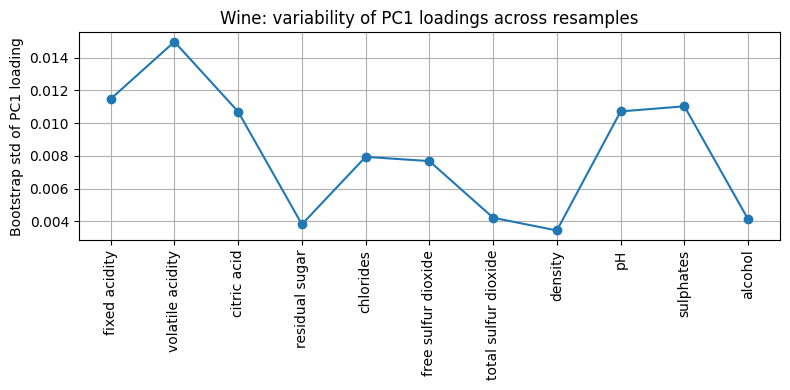

In [32]:
# Lightweight bootstrap stability for Wine PC1 loadings
rng = np.random.default_rng(42)
B = 80  # number of bootstrap resamples (kept moderate for speed)

loadings_b = []
for _ in range(B):
    idx = rng.integers(0, Xw.shape[0], size=Xw.shape[0])
    Xb = Xw[idx, :]
    Xb_std = StandardScaler().fit_transform(Xb)
    p = PCA(n_components=3, random_state=42).fit(Xb_std)
    w = p.components_[0]
    if w[np.argmax(np.abs(w))] < 0:
        w = -w
    loadings_b.append(w)

loadings_b = np.vstack(loadings_b)

df_boot = pd.DataFrame(loadings_b, columns=wine_features)
summary = pd.DataFrame({
    "feature": wine_features,
    "pc1_loading_mean": df_boot.mean(axis=0).values,
    "pc1_loading_std": df_boot.std(axis=0).values,
    "abs_mean": np.abs(df_boot.mean(axis=0).values)
}).sort_values("abs_mean", ascending=False)

display(summary.head(12))

plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(wine_features)), summary.set_index("feature").loc[wine_features, "pc1_loading_std"].values, marker="o")
plt.xticks(np.arange(len(wine_features)), wine_features, rotation=90)
plt.ylabel("Bootstrap std of PC1 loading")
plt.title("Wine: variability of PC1 loadings across resamples")
plt.grid(True)
plt.tight_layout()
plt.show()

## ۲۱) مقیاس‌بندی مقاوم در برابر outlier (RobustScaler)

استانداردسازی (z-score) از میانگین و انحراف معیار استفاده می‌کند. اگر دیتاست outlierهای شدید داشته باشد، این آماره‌ها می‌توانند منحرف شوند.
یک جایگزین رایج `RobustScaler` است که از میانه و IQR استفاده می‌کند.

یک الگوی مفید در EDA:
- PCA با `StandardScaler` را به‌عنوان نمای پایه اجرا کنید؛
- سپس PCA با `RobustScaler` را اجرا کنید تا ببینید مؤلفه‌های اصلی چقدر تغییر می‌کنند.

در ادامه PCA را روی Iris (پس از تزریق outlier) با دو مقیاس‌بندی مقایسه می‌کنیم.

In [33]:
# Compare StandardScaler vs RobustScaler under an outlier perturbation (Iris)
X_iris = df_iris[feature_cols].to_numpy(dtype=float)

X_out2 = X_iris.copy()
X_out2[0, :] = X_out2[0, :] + 10.0  # strong outlier

Xs_std = StandardScaler().fit_transform(X_out2)
p_std = PCA(n_components=2, random_state=42).fit(Xs_std)

Xs_rob = RobustScaler().fit_transform(X_out2)
p_rob = PCA(n_components=2, random_state=42).fit(Xs_rob)

print("Explained variance ratio (StandardScaler):", p_std.explained_variance_ratio_)
print("Explained variance ratio (RobustScaler):  ", p_rob.explained_variance_ratio_)

w_std = p_std.components_[0]
w_rob = p_rob.components_[0]
cosang = np.abs(np.dot(w_std, w_rob) / (np.linalg.norm(w_std) * np.linalg.norm(w_rob)))
print("Absolute cosine between PC1 (std vs robust):", cosang)

Explained variance ratio (StandardScaler): [0.75095664 0.22198469]
Explained variance ratio (RobustScaler):   [0.80432326 0.18349689]
Absolute cosine between PC1 (std vs robust): 0.6491198701566269


## ۲۲) نکته پایانی: PCA در EDA در برابر PCA در تولید

در EDA، PCA عمدتاً برای موارد زیر است:
- تصویرسازی؛
- درک ساختار همبستگی؛
- تشخیص افزونگی و نقاط غیرعادی؛
- تولید فرضیه و اشکال‌زدایی کیفیت داده.

در تولید، PCA گزینشی‌تر استفاده می‌شود زیرا:
- می‌تواند بُعد را کم کند و سرعت مدل‌های پایین‌دستی را افزایش دهد؛
- به چندهمخطی در مدل‌های خطی کمک کند؛
- اما تفسیرپذیری را کاهش می‌دهد و ممکن است نسبت به تغییر توزیع (distribution shift) حساس باشد.

یک راهنمای عملی این است که PCA را ابتدا به‌عنوان **ابزار EDA و نمونه‌سازی** ببینید. اگر بعداً در تولید نگه داشته شد، آن را تحت موارد زیر اعتبارسنجی کنید:
- جداسازی درست آموزش/اعتبارسنجی (بدون نشت)؛
- سناریوهای drift؛
- پایش (آیا واریانس‌های توضیح‌داده‌شده یا خطای بازسازی در زمان تغییر می‌کند؟).

## ۲۳) چک‌لیست عملی PCA برای EDA

قبل از اینکه به یک نمودار PCA اعتماد کنید یا درباره $k$ تصمیم بگیرید، این چک‌لیست را مرور کنید:

1) **نوع داده:** آیا فقط ستون‌های عددی را به PCA می‌دهید (یا پس از one-hot از روش مناسب تنک مثل TruncatedSVD استفاده می‌کنید)؟
2) **مقادیر گمشده:** آیا NaNها را مدیریت کرده‌اید (impute یا حذف)؟ PCA با دادهٔ دارای مقدار گمشده درست کار نمی‌کند.
3) **انتخاب مقیاس:** آیا تفاوت PCA کوواریانس و PCA همبستگی را توجیه کرده‌اید؟ برای واحدهای متفاوت، استانداردسازی معمولاً امن‌تر است.
4) **outlier:** آیا نقاط افراطی جهت مؤلفه‌ها را می‌چرخانند؟ مقیاس‌بندی مقاوم یا حذف خطاهای واضح را امتحان کنید و نتیجه را مقایسه کنید.
5) **واریانس توضیح‌داده‌شده:** آیا نمودار Scree و واریانس تجمعی «زانوی» مشخصی دارند یا واریانس به‌صورت یکنواخت پخش است؟
6) **تفسیر:** آیا بارگذاری‌ها (یا بارگذاری‌های مربعی) با انتظارهای حوزه‌ای هم‌خوان‌اند؟
7) **پایداری:** آیا بارگذاری‌ها تحت بازنمونه‌گیری (حداقل به‌صورت کیفی) پایدارند؟ اگر نه، با احتیاط تفسیر کنید.
8) **کاربرد پایین‌دستی:** اگر PCA قبل از مدل استفاده شود، پایپ‌لاین بدون نشت و ارزیابی end-to-end را حتماً بررسی کنید.

این چک‌لیست باعث می‌شود PCA از یک «نمودار زیبا» به یک ابزار EDA منظم و قابل اتکا تبدیل شود.

## ۱۵) جمع‌بندی

PCA را از چند دیدگاه مکمل یاد گرفتید:
- بهینه‌سازی: بیشینه کردن $w^\top S w$ تحت قید $w^\top w = 1$؛
- تجزیه مقدارِ ویژه و واریانس توضیح‌داده‌شده؛
- ارتباط با SVD و پایداری عددی؛
- تقریب کم‌رتبهٔ بهینه و بازسازی؛
- سفیدسازی و نامرتبط‌سازی؛
- الگوهای کاربردی برای داده‌های عددی و ترکیبی.

همچنین پیاده‌سازی‌های پایتونی را روی چند دیتاست همین مخزن تمرین کردید.

## ۱۶) تمرین‌ها (پیشنهادی)

1) **آزمایش مقیاس‌بندی (Wine):** PCA را بدون `StandardScaler()` اجرا کنید و واریانس توضیح‌داده‌شده و بارگذاری‌ها را مقایسه کنید. کدام ویژگی‌ها غالب می‌شوند و چرا؟
2) **منحنی‌های بازسازی:** برای Wine Quality نیز MSE بازسازی بر حسب $k$ را محاسبه کنید و با Iris مقایسه کنید. کدام دیتاست «کم‌بُعدتر» است؟
3) **پایداری نسبت به outlier:** PCA را پس از حذف outlier با کوانتایل‌ها یا با `RobustScaler` تکرار کنید. آیا PCهای اصلی تغییر می‌کنند؟
4) **مدل‌سازی با PCA:** کیفیت Wine را به low/high باین کنید و `StandardScaler -> LogisticRegression` را با `StandardScaler -> PCA(k) -> LogisticRegression` برای چند مقدار $k$ مقایسه کنید.
5) **عوامل نهفته در دادهٔ ترکیبی:** در Diamonds، وزن‌های بزرگ مؤلفه‌های ۲ و ۳ را بررسی کنید. آیا بیشتر به دسته‌ها (cut/color/clarity) مربوط‌اند یا به ویژگی‌های عددی؟
6) **PCA تدریجی:** اندازهٔ بچ را در `IncrementalPCA` تغییر دهید و واریانس توضیح‌داده‌شده را با PCA استاندارد مقایسه کنید.

برای هر آزمایش یک تفسیر کوتاه (۲ تا ۵ جمله) بنویسید؛ PCA به همان اندازه که محاسبه است، تحلیل و استدلال هم هست.